
<center> <img src=https://salesupnow.ru/storage/app/media/pipeople.png align="center" width="300"/> </center>

## <center> Проект: Сегментирование клиентов онлайн-магазина подарков

## 1. Знакомство с данными 

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from mpl_toolkits.mplot3d import Axes3D

import plotly.graph_objs as go
import plotly.express as px
from plotly.subplots import make_subplots

from sklearn import mixture
from sklearn import manifold
from sklearn import pipeline
from sklearn import preprocessing
from sklearn import cluster
from sklearn import metrics
from sklearn import model_selection
from sklearn import decomposition
from sklearn import ensemble
import warnings 

from IPython.display import display, HTML

warnings.filterwarnings("ignore")

plt.rcParams["patch.force_edgecolor"] = True

Первым делом необходимо понять, с какими данными нам предстоит работать, и произвести базовую предобработку данных, переведя признаки в необходимые для дальнейшей работы форматы.


Для начала давайте познакомимся с нашими данными:

In [2]:
data = pd.read_csv(
    "data/customer_segmentation_project.csv", 
    encoding="ISO-8859-1", 
    dtype={'CustomerID': str,'InvoiceID': str}
)
print('Data shape: {}'.format(data.shape))
data.head(5)

Data shape: (541909, 8)


,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,12/1/2010 8:26,2.55,17850,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,12/1/2010 8:26,3.39,17850,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,12/1/2010 8:26,2.75,17850,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,12/1/2010 8:26,3.39,17850,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,12/1/2010 8:26,3.39,17850,United Kingdom


Итак, у нас есть данные о более чем полумиллионе транзакций. Каждая из них описывается следующими признаками:

* *InvoiceNo* — номер счёта-фактуры (уникальный номинальный шестизначный номер, присваиваемый каждой транзакции; буква "*C*" в начале кода указывает на отмену транзакции);
* *Stock Code* — код товара (уникальное пятизначное целое число, присваиваемое каждому отдельному товару);
* *Description* — название товара;
* *Quantity* — количество каждого товара за транзакцию; 
* *InvoiceDate* — дата и время выставления счёта/проведения транзакции;
* *UnitPrice* — цена за единицу товара в фунтах стерлингов;
* *CustomerID* — идентификатор клиента (уникальный пятизначный номер, однозначно присваиваемый каждому клиенту);
* *Country* — название страны, в которой проживает клиент.

Проведём анализ структуры таблицы.

### 1.1 Структура данных, представленных в таблице

In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   InvoiceNo    541909 non-null  object 
 1   StockCode    541909 non-null  object 
 2   Description  540455 non-null  object 
 3   Quantity     541909 non-null  int64  
 4   InvoiceDate  541909 non-null  object 
 5   UnitPrice    541909 non-null  float64
 6   CustomerID   406829 non-null  object 
 7   Country      541909 non-null  object 
dtypes: float64(1), int64(1), object(6)
memory usage: 33.1+ MB


Данные представлены категориальным типом object и числовыми int, float

### 1.2 Пропуски в данных

In [4]:
data.isnull().sum()

InvoiceNo           0
StockCode           0
Description      1454
Quantity            0
InvoiceDate         0
UnitPrice           0
CustomerID     135080
Country             0
dtype: int64

Столбцы, в которых есть пропуски:
* *Description*
* *CustomerID*

### 1.3 Преобразование в datetime
Преобразуем столбец InvoiceDate в формат datetime.
Посмотрим, за какой промежуток времени представлены данные:

In [5]:
data['InvoiceDate'] = pd.to_datetime(data['InvoiceDate'])
print('Начальная дата', data['InvoiceDate'].min())
print('Конечная дата', data['InvoiceDate'].max())

Начальная дата 2010-12-01 08:26:00
Конечная дата 2011-12-09 12:50:00


### 1.4 Исследование данных

Максимальное и минимальное количество товаров в заказе (Quantity)

In [6]:
data['Quantity'].describe()

count    541909.000000
mean          9.552250
std         218.081158
min      -80995.000000
25%           1.000000
50%           3.000000
75%          10.000000
max       80995.000000
Name: Quantity, dtype: float64

Стоимость самого дешёвого товара (за исключением товаров с отрицательной стоимостью)

In [7]:
data[data['UnitPrice'] >= 0]['UnitPrice'].sort_values()

414960        0.00
382679        0.00
382678        0.00
323389        0.00
382666        0.00
            ...   
15016     13541.33
43703     16453.71
43702     16888.02
524602    17836.46
222681    38970.00
Name: UnitPrice, Length: 541907, dtype: float64

Как видим, есть две транзакции, в одной из которых указано более 80 тысяч единиц товара, а в другой — отрицательное количество товаров (вероятно, это свидетельствует об отмене транзакции). Чтобы понять природу таких транзакций, нам нужно исследовать их более детально.

Также видим, что есть товары, которые «отдаются даром» — они тоже нуждаются в дополнительной проверке.

Найдем количество уникальных клиентов, которые покупали товары за период выгрузки датасета

In [8]:
print('Количество уникальных клиентов:', data['CustomerID'].nunique())

Количество уникальных клиентов: 4372


Количество уникальных стран, которые содержатся в столбце Country (исключая специальный код 'Unspecified', обозначающий неопределенную страну)

In [9]:
print('Количество уникальных стран:', data[data['Country'] != 'Unspecified']['Country'].nunique())

Количество уникальных стран: 37


Идентификатор самого популярного товара (StockCode):

In [10]:
data[['StockCode', 'Description']].mode()

,StockCode,Description
0,85123A,WHITE HANGING HEART T-LIGHT HOLDER


## 2. Предобработка и очистка данных

На этом этапе нам подготовим наш датасет для дальнейшего моделирования, произведя очистку данных.


### 2.1 Удаление пропущенных значений

In [11]:
# количество пропусков
print('Всего пропущенных значений:', data.isnull().sum().sum())
# удалим строки с пропущенными значениями
data.dropna(inplace=True)
print('Количество строк после удаления:', data.shape[0])

Всего пропущенных значений: 136534
Количество строк после удаления: 406829


### 2.2 Удаление дубликатов
Следом за пропусками проверим наличие дубликатов.

In [12]:
# количество дубликатов
print('Количество дубликатов:', data.duplicated().sum())
# удаление дубликатов
data.drop_duplicates(inplace=True)
print(data.shape)

Количество дубликатов: 5225
(401604, 8)


Ранее мы заметили, что в столбце с количеством товара есть отрицательные значения. Давайте разберемся, откуда они взялись. Выведем первые 5 строк таблицы, в которой столбец Quantity меньше 0.

In [13]:
negative_quantity = data[data['Quantity']<0]
print('Count of entries with a negative number: {}'.format(negative_quantity.shape[0]))
negative_quantity.head()

Count of entries with a negative number: 8872


,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
141,C536379,D,Discount,-1,2010-12-01 09:41:00,27.50,14527,United Kingdom
154,C536383,35004C,SET OF 3 COLOURED FLYING DUCKS,-1,2010-12-01 09:49:00,4.65,15311,United Kingdom
235,C536391,22556,PLASTERS IN TIN CIRCUS PARADE,-12,2010-12-01 10:24:00,1.65,17548,United Kingdom
236,C536391,21984,PACK OF 12 PINK PAISLEY TISSUES,-24,2010-12-01 10:24:00,0.29,17548,United Kingdom
237,C536391,21983,PACK OF 12 BLUE PAISLEY TISSUES,-24,2010-12-01 10:24:00,0.29,17548,United Kingdom


Таких записей почти девять тысяч. Не похоже на какую-то ошибку или выбросы, ведь случаев слишком много.

При просмотре таблицы можно заметить следующее:

* Номер заказа (*InvoiceNo*) и код товара (*StockCode*) могут содержать не только числа, но и символы.
* Как было сказано в описании датасета, символ "*C*" перед номером заказа указывает на возврат. То есть, по идее, в таблице должна также находиться запись с точно такими же идентификаторами клиента и товара, но c номером заказа без символа "*C*" и c положительным количеством товара.
* Код товара может содержать различные специальные символы: например, символ "*D*", судя по описанию товара (столбец *Description*), означает наличие скидки.
* Как на каждый уникальный товар, так и на его возврат заводится отдельная транзакция (запись в таблице).

Проверим, что все записи из таблицы с отрицательным количеством товара действительно являются возвратными транзакциями. Если транзакция не является возвратом, но содержит отрицательное количество товара, это будет поводом считать её выбросом.

In [14]:
# количество транзакций, содержащих символ "С" в номере заказа
negative_quantity['InvoiceNo'].str.contains(r'\bC').sum()

8872

Все транзакции с отрицательным количеством товара являются возвратами.

Давайте подробнее разберёмся с возвратами. Сейчас на каждый уникальный товар заведена отдельная строка в таблице — это мешает определить общее количество возвратов.

Чтобы подсчитать число возвратов, сначала необходимо определить, сколько уникальных товаров указано в транзакции (корзине/basket) для каждой уникальной пары «клиент-заказ»:


In [15]:
temp = data.groupby(by=['CustomerID', 'InvoiceNo'], as_index=False)['InvoiceDate'].count()
nb_products_per_basket = temp.rename(columns = {'InvoiceDate':'Number of products'})
nb_products_per_basket.head()

,CustomerID,InvoiceNo,Number of products
0,12346,541431,1
1,12346,C541433,1
2,12347,537626,31
3,12347,542237,29
4,12347,549222,24


Добавим во вспомогательную таблицу nb_products_per_basket признак отмены заказа (order_canceled): он равен 1, если транзакция является возвратом, и 0 — в противном случае.

In [16]:
nb_products_per_basket['order_canceled'] = nb_products_per_basket['InvoiceNo'].apply(lambda x: 1 if x[0]=='C' else 0)
nb_products_per_basket['order_canceled'].value_counts(True) * 100

0    83.533123
1    16.466877
Name: order_canceled, dtype: float64

Более 16 % уникальных заказов являются возвратами.

Взглянем на отмененные заказы:

In [17]:
nb_products_per_basket[nb_products_per_basket['order_canceled']==1].head()

,CustomerID,InvoiceNo,Number of products,order_canceled
1,12346,C541433,1,1
23,12352,C545329,2,1
24,12352,C545330,1,1
25,12352,C547388,7,1
39,12359,C549955,2,1


Найдем в таблице со всеми транзакциями записи принадлежащие клиенту с идентификатором 12346:


In [18]:
data[data['CustomerID'] == '12346']

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
61619,541431,23166,MEDIUM CERAMIC TOP STORAGE JAR,74215,2011-01-18 10:01:00,1.04,12346,United Kingdom
61624,C541433,23166,MEDIUM CERAMIC TOP STORAGE JAR,-74215,2011-01-18 10:17:00,1.04,12346,United Kingdom


Итак, вот пример пары «заказ-отмена». Обратим внимание на столбцы *StockCode*, *UnitPrice*, *CustomerID* и *Quantity*, сравним их для двух транзакций. 

Выдвигаем гипотезу: для каждой отменённой транзакции в базе данных (таблица data) существует её аналог с тем же кодом товара, идентификатором клиента и противоположным значением количества товара.

In [19]:
data.head(2)

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850,United Kingdom


In [20]:
negative_quantity.head(2)

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
141,C536379,D,Discount,-1,2010-12-01 09:41:00,27.50,14527,United Kingdom
154,C536383,35004C,SET OF 3 COLOURED FLYING DUCKS,-1,2010-12-01 09:49:00,4.65,15311,United Kingdom


In [21]:
# создадим список для транзакций с отрицательным количеством товаров
value_negative = []
#  в цикле перебираем и записываем в список кортеж с тремя параметрами транзакции, признак Quantity умножаем на -1
for index, row in negative_quantity.iterrows():
    value_negative.append((row['StockCode'], row['CustomerID'], -1*row['Quantity']))
# выводим количество транзакций с отрицательным количеством товара
print(len(value_negative))

# создадим список для транзакций с положительным количеством товаров из исходной таблицы
value_positive = []
# в цикле перебираем строки исходной таблицы и создаем кортеж с параметрами тремя параметрами транзакции
for index, row in data.iterrows():
    value = (row['StockCode'], row['CustomerID'], row['Quantity'])
    # проверяем его совпадение с кортежем из списка value_negative
    if value in value_negative:
        # при совпадении добавляем в список
        value_positive.append(value)
print(len(value_positive))

8872
5477


Количество транзакций с положительным и отрицательным количеством товара у одного клиента не совпадает. Гипотеза не верна

Приведем контр-пример, на котором "споткнулась" наша прошлая гипотеза. Посмотрим на клиента с идентификатором 14527:

In [22]:
data[data['CustomerID'] == '14527'].head(5)

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
141,C536379,D,Discount,-1,2010-12-01 09:41:00,27.50,14527,United Kingdom
8963,537159,22112,CHOCOLATE HOT WATER BOTTLE,6,2010-12-05 13:17:00,4.95,14527,United Kingdom
8964,537159,22111,SCOTTIE DOG HOT WATER BOTTLE,1,2010-12-05 13:17:00,4.95,14527,United Kingdom
8965,537159,21479,WHITE SKULL HOT WATER BOTTLE,1,2010-12-05 13:17:00,3.75,14527,United Kingdom
8966,537159,22114,HOT WATER BOTTLE TEA AND SYMPATHY,6,2010-12-05 13:17:00,3.95,14527,United Kingdom


Обратим внимание на первую строку, в которой располагается заказ C536379 с признаком отмены — противоположных ему аналогов по количеству товаров мы не найдём. Причина кроется в типе товара: данный товар обозначен как товар со скидкой (StockCode), и, по-видимому, для таких транзакций нет аналогов с положительным числом товаров в заказе. Учтём это наблюдение на будущее.

Выдвигаем новую гипотезу: для каждой отменённой транзакции в базе данных (таблица data) существует её аналог с тем же кодом товара, идентификатором клиента и противоположным значением количества товара, если на товар не распространяются скидки.

In [23]:
# создадим список для транзакций с отрицательным количеством товаров и без скидки
value_negative_not_discount = []
#  в цикле перебираем и записываем в список кортеж с тремя параметрами транзакции, признак Quantity умножаем на -1
for index, row in negative_quantity[negative_quantity['StockCode'] != 'D'].iterrows():
    value_negative_not_discount.append((row['StockCode'], row['CustomerID'], -1*row['Quantity']))
# выводим количество транзакций с отрицательным количеством товара
print(len(value_negative_not_discount))

8795


Количество транзакций уменьшилось с 8872 до 8795, гипотеза не подтвердилась.

Посмотрим, где кроется наша проблема. В качестве контр-примера приведем транзакции, относящиеся к клиенту с идентификатором 15311 и товаром под кодом 35004C:


In [24]:
data[(data['CustomerID'] == '15311') & (data['StockCode'] == '35004C')]

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
154,C536383,35004C,SET OF 3 COLOURED FLYING DUCKS,-1,2010-12-01 09:49:00,4.65,15311,United Kingdom
9200,537195,35004C,SET OF 3 COLOURED FLYING DUCKS,12,2010-12-05 13:55:00,4.65,15311,United Kingdom
18196,C537805,35004C,SET OF 3 COLOURED FLYING DUCKS,-1,2010-12-08 13:18:00,4.65,15311,United Kingdom
28630,538651,35004C,SET OF 3 COLOURED FLYING DUCKS,12,2010-12-13 15:07:00,4.65,15311,United Kingdom
39381,C539640,35004C,SET OF 3 COLOURED FLYING DUCKS,-3,2010-12-20 15:27:00,4.65,15311,United Kingdom
44157,540157,35004C,SET OF 3 COLOURED FLYING DUCKS,12,2011-01-05 11:41:00,4.65,15311,United Kingdom
59542,541293,35004C,SET OF 3 COLOURED FLYING DUCKS,12,2011-01-17 13:39:00,4.65,15311,United Kingdom
78333,C542866,35004C,SET OF 3 COLOURED FLYING DUCKS,-2,2011-02-01 12:14:00,4.65,15311,United Kingdom


* На первой строке мы видим заказ с отменой (номер заказа начинается с символа C). Однако возникает вопрос: на какой заказ пришла эта отмена, ведь более ранних записей о транзакциях, связанных с этим клиентом, нет.
Ответ состоит в том, что заказ на покупку данного товара от клиента поступил раньше декабря 2010 года, а этих данных в нашей таблице нет. Это очень популярная проблема, которая возникает практически при любой работе с транзакциями: есть только фрагмент из общих данных, однако неизвестно, что предшествовало этому фрагменту.

* По двум следующим строкам видно, что клиент может отменить не весь заказ, а только его часть (5 декабря клиент покупает 12 единиц товара, а 8 декабря оформляет возврат только на одну единицу товара). Мы должны принять это во внимание на будущее

Итак, теперь мы знаем все особенности отмены заказов. При сегментировании клиентов мы будем определять их покупательскую способность, а для этого очень важно учитывать возвраты товаров. Поэтому давайте создадим в данных о транзакциях признак QuantityCanceled, который будет указывать на количество возвращённого впоследствии товара для каждой транзакции. 

Сразу обговорим, что мы не будем учитывать сложные пограничные случаи:
1. Отменённая транзакция не имеет противоположной (на транзакцию-возврат не нашлось ни одной транзакции на покупку).
2. Количество возвращённого товара в транзакции-возврате больше, чем количество товара, которое указано в любой из отдельных транзакций на покупку (это случай, когда клиент сделал несколько заказов одного и того же товара, а потом оформил возврат на все товары разом).


Подготовим функцию `get_quantity_canceled()`. Она принимает на вход таблицу с транзакциями и возвращает объект Series — столбец, в котором указано количество возвращённого впоследствии товара для каждой транзакции. На основе результата работы этой функции мы создаём в таблице с транзакциями новый столбец QuantityCanceled.


In [25]:
def get_quantity_canceled(data):
    # Инициализируем Series той же длины, что и столбцы таблицы, нулями
    quantity_canceled = pd.Series(np.zeros(data.shape[0]), index=data.index)    
    negative_quantity = data[(data['Quantity'] < 0)].copy()
    for index, col in negative_quantity.iterrows():
        # Создаем DataFrame из всех контрагентов
        df_test = data[(data['CustomerID'] == col['CustomerID']) &
                       (data['StockCode'] == col['StockCode']) & 
                       (data['InvoiceDate'] < col['InvoiceDate']) & 
                       (data['Quantity'] > 0)].copy()
        # Транзакция-возврат не имеет контрагента - ничего не делаем
        if (df_test.shape[0] == 0): 
            continue
        # Транзакция-возврат имеет ровно одного контрагента
        # Добавляем количество отмененного в столбец QuantityCanceled 
        elif (df_test.shape[0] == 1): 
            index_order = df_test.index[0]
            quantity_canceled.loc[index_order] = -col['Quantity']       
        # Транзакция-возврат имеет несколько контрагентов
        # Задаем количество отмененного товара в столбец QuantityCanceled для той транзакции на покупку,
        # в которой количество товара > -(количество товаров в транзакции-возврате)
        elif (df_test.shape[0] > 1): 
            df_test.sort_index(axis=0 ,ascending=False, inplace = True)        
            for ind, val in df_test.iterrows():
                if val['Quantity'] < -col['Quantity']: 
                    continue
                quantity_canceled.loc[ind] = -col['Quantity']
                break    
    return quantity_canceled

quantity_canceled = get_quantity_canceled(data)
quantity_canceled
# добавим столбец в наши данные
data['QuantityCanceled'] = quantity_canceled

Теперь, когда мы разобрались с транзакциями-возвратами, они больше нам не понадобятся. 
Удалим из таблицы транзакции, в поле которых указано отрицательное количество товара.  

In [27]:
data = data[data['Quantity'] > 0]
data.shape[0]

392732

Следующая проблема — это специальные виды транзакций. Например, ранее мы уже видели, что для товаров со скидкой признак StockCode обозначен как 'D'. Давайте проверим, бывают ли другие специальные коды.


С помощью регулярных выражений найдём такие коды товаров (StockCode), которые начинаются с латинских букв (при этом коды могут содержать цифры). 

Поиск подстрок в столбце организуем с помощью str.contains(). В качестве шаблона для поиска используем строку '^[a-zA-Z]+'. Параметр regex установим в значение True.

In [28]:
# создадим маску для поиска специальных кодов
mask = data['StockCode'].str.contains('^[a-zA-Z]+', regex=True)
# уникальные спецкоды
print(data[mask]['StockCode'].unique())
# таблица без специальных транзакций
data = data[~mask]
print(data.shape[0])

['POST' 'C2' 'M' 'BANK CHARGES' 'PADS' 'DOT']
391183


Ранее при просмотре описательных статистик мы видели, что на некоторые товары установлена цена в 0 фунтов стерлингов. 

In [29]:
print("транзакций с нулевой ценой товара:", data[data['UnitPrice'] == 0].shape[0])
# удалим нулевые транзакции
data = data[data['UnitPrice'] != 0]
print('Количество транзакций после удаления:', data.shape[0])

транзакций с нулевой ценой товара: 33
Количество транзакций: 391150


Этап очистки данных завершён.

## 3. Разведывательный анализ данных

Перед нами стоят следующие задачи:
* понять, клиенты из каких стран покупают больше и чаще;
* узнать, присутствует ли в продажах сезонность (когда покупают чаще);
* создать новые признаки, которые в дальнейшем понадобятся при формировании датасета о клиентах.

### 3.1 Распределение клиентов в разрезе стран
Выясним, в каких странах живут клиенты.

Построим график, отражающий количество уникальных клиентов в каждой из стран. 

In [30]:
# выполним группировку количества уникальных клиентов по странам
country_group = data.groupby(by=['Country'], as_index=False)['CustomerID'].agg('nunique')
country_group.sort_values(by='CustomerID', ascending=False).head()

,Country,CustomerID
35,United Kingdom,3916
14,Germany,94
13,France,87
30,Spain,30
3,Belgium,25


Наибольшее количество уникальных клиентов живет в Великобритании

In [31]:
#строим график
fig = px.choropleth(
    data_frame=country_group, #DataFrame
    locations="Country", #столбец с локациями
    locationmode = "country names", #режим сопоставления локаций с базой Plotly
    color="CustomerID", #от чего зависит цвет
    # animation_frame="date", #анимационный бегунок
    range_color=[0,200], #диапазон цвета
    title='Customers by countries', #заголовок
    width=800, #ширина
    height=500, #высота
    color_continuous_scale='Reds' #палитра цветов
)

#отображаем график
fig.show()

Из графика также видим, что большинство клиентов из Великобритании

### 3.2 Распределение заказов в разрезе стран

Постройте визуализацию и выделите топ-3 стран по количеству поступающих заказов.

In [32]:
# выполним группировку количества уникальных заказов по странам
invoice_group = data.groupby(by=['Country'], as_index=False)['InvoiceNo'].agg('nunique')
# ТОП-5 стран по количеству заказов
invoice_group.sort_values(by='InvoiceNo', ascending=False).head(5)

,Country,InvoiceNo
35,United Kingdom,16579
14,Germany,443
13,France,379
10,EIRE,256
3,Belgium,98


In [33]:
#строим график
fig = px.treemap(
    data_frame=invoice_group, #DataFrame
    path=['Country'], #категориальный признак, для которого строится график
    values='InvoiceNo', #параметр, который сравнивается
    height=500, #высота
    width=1000, #ширина
    title='Number of orders by country', #заголовок
    labels={'InvoiceNo':'Number of orders'}
)

#отображаем график
fig.show()

Топ-3 стран по количеству поступающих заказов:
1. Великобритания
2. Германия
3. Франция

Добавим в датасет общую цену заказа, назовём её TotalPrice.
Общая цена заказа рассчитывается как:
 
 **общая цена = цена за единицу товара * (количество товаров в заказе - количество возвращённых товаров).**

In [34]:
data['TotalPrice'] = data['UnitPrice'] * (data['Quantity'] - data['QuantityCanceled'])

21.0

### 3.3 Объем выручки в разрезе стран

Построим визуализацию и выделим топ-3 стран, клиенты из которых приносят компании больше всего выручки

In [35]:
# Группировка по странам суммарной выручки
totalprice_group = data.groupby('Country', as_index=False)['TotalPrice'].sum()
totalprice_group.sort_values(by='TotalPrice', ascending=False).head(5)

,Country,TotalPrice
35,United Kingdom,6797691.44
23,Netherlands,283443.54
10,EIRE,247074.57
14,Germany,201520.71
13,France,181529.63


In [36]:
#строим график
fig = px.treemap(
    data_frame=totalprice_group, #DataFrame
    path=['Country'], #категориальный признак, для которого строится график
    values='TotalPrice', #параметр, который сравнивается
    height=500, #высота
    width=1000, #ширина
    title='Revenue by Country', #заголовок
    labels={'TotalPrice':'Revenue'}
)

#отображаем график
fig.show()

Топ-3 стран, клиенты из которых приносят компании больше всего выручки:
1. Великобритания
2. Нидерланды
3. Ирландия

### 3.4 Работа с временными характеристиками
Добавим в таблицу с транзакциями признаки месяца, дня недели и часа совершения покупки.

Построим визуализацию, отражающую распределение суммарной выручки от заказов по месяцам.

In [37]:
# добавим столбец с месяцем заказа
data['InvoiceMonth'] = pd.to_datetime(data['InvoiceDate']).dt.month
# добавим столбец с неделей заказа
data['InvoiceWeekday'] = pd.to_datetime(data['InvoiceDate']).dt.weekday
# добавим столбец с часом заказа
data['InvoiceHour'] = pd.to_datetime(data['InvoiceDate']).dt.hour
data.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,QuantityCanceled,TotalPrice,InvoiceMonth,InvoiceWeekday,InvoiceHour
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850,United Kingdom,0.0,15.30,12,2,8
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850,United Kingdom,0.0,20.34,12,2,8
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850,United Kingdom,0.0,22.00,12,2,8
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850,United Kingdom,0.0,20.34,12,2,8
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850,United Kingdom,0.0,20.34,12,2,8


In [38]:
# группируем данные по месяцам и суммируем выручку
revenue_month = data.groupby(by='InvoiceMonth', as_index=False)['TotalPrice'].sum()
display(revenue_month)
# строим график
fig = px.bar(revenue_month,
             x='InvoiceMonth',
             y='TotalPrice',
             title='Revenue by month',
             labels={'TotalPrice':'Revenue', 'InvoiceMonth':'Month'})
fig.show()

,InvoiceMonth,TotalPrice
0,1,453560.68
1,2,436043.09
2,3,571941.01
3,4,447922.86
4,5,647403.81
5,6,601238.45
6,7,581019.35
7,8,614704.38
8,9,928554.44
9,10,967436.46


Наибольшая выручка у магазина в ноябре. Такой результат можно объяснить так: ноябрь предшествует декабрю, а в декабре отмечаются католическое Рождество и Новый год. Максимальный рост продаж видим в преддверии этих праздников.

### 3.5 Количество заказов в разрезе дня недели
Построим визуализацию, отражающую распределение среднего количества заказов по дням недели.

In [40]:
# выполним группировку количества уникальных заказов по дням недели
invoice_daygroup = data.groupby(by=['InvoiceWeekday','InvoiceNo'], as_index=False).count().groupby('InvoiceWeekday', as_index=False)['InvoiceNo'].count()
invoice_daygroup.sort_values(by='InvoiceNo', ascending=False)

# строим график
fig = px.bar(invoice_daygroup,
             x='InvoiceWeekday',
             y='InvoiceNo',
             title='Orders by day of week',
             labels={'InvoiceWeekday':'Day of week', 'InvoiceNo':'Count of orders'})
fig.show()

В субботу (день недели 5) не совершено ни одного заказа. Возможно, суббота является выходным днём и транзакции в этот день не совершаются, а может быть, это ошибка в данных.

### 3.6 Количество заказов в разрезе часа дня
Выделим дату из признака времени совершения транзакции.
Сгруппируем данные по датам и часам совершения транзакции и найдем количество заказов на каждый день-час. Затем найдем среднее количество ежедневно поступающих заказов в каждый из часов.

Построим визуализацию, отражающую распределение среднего количества ежедневно поступающих заказов по времени суток (часу совершения транзакции).

In [41]:
# выделим дату из признака времени совершения транзакции
data['Date'] = data['InvoiceDate'].dt.date
# удаляем дубликаты и оставляем уникальные номера заказов, группируем по дате и часу считаем количество, группируем по часу считаем среднее
hour_group = data.drop_duplicates(subset='InvoiceNo').groupby(['Date', 'InvoiceHour'], as_index=False)['InvoiceNo'].count().groupby(['InvoiceHour'], as_index=False).mean()
display(hour_group)

,InvoiceHour,InvoiceNo
0,6,1.000000
1,7,1.260870
2,8,2.715686
3,9,5.488095
4,10,7.273927
5,11,7.440789
6,12,10.219672
7,13,8.685430
8,14,7.478405
9,15,6.714286


In [42]:
# строим график
fig = px.bar(hour_group,
             x='InvoiceHour',
             y='InvoiceNo',
             title='Orders by hour',
             labels={'InvoiceHour':'Hour', 'InvoiceNo':'Count of orders'})
fig.show()

* Больше всего заказов совершается в дневное время, в интервале от 10 до 15 часов.
* С 21 часа до 6 утра (не включительно) заказы не поступают.

## 4. RFM-сегментация клиентов: часть 1

Нам предстоит сформировать признаки, на основе которых мы будем производить сегментацию клиентов.

Для этого воспользуемся популярным методом для анализа потребительской ценности под названием RFM. 

Метод заключается в группировке клиентов на основе следующих параметров:
* Recency (Давность) — давность последней покупки клиента;
* Frequency (Частота) — общее количество покупок клиента;
* Monetary Value (Денежная ценность) — сколько денег потратил клиент.


Суть RFM-анализа состоит в том, что мы разделяем всех клиентов на группы в зависимости от того, как давно они сделали последнюю покупку, как часто покупали и насколько большой была сумма их заказов.

Например, вот так может выглядеть интерпретация кластеров для случая RF-сегментации (анализа на основе давности и частоты заказов клиента):

<img src=https://retailrocket.ru/wp-content/uploads/2017/06/rfm-1.png>

Задача маркетологов — вести клиента в зону лояльных.

Мы можем рассчитать RFM-характеристики для каждого из клиентов в нашем датасете и на их основе с помощью методов кластеризации построить подобные сегменты клиентов, привязанные к нашим данным.

### 4.1 RFM таблица

Приступим к созданию нашей RFM-таблицы. 

Чтобы получить RFM-таблицу, нам необходимо сгруппировать данные по идентификаторам клиента и рассчитать следующие  агрегированные характеристики:

* Recency для i-го клиента рассчитывается как разница между датой и временем последнего заказа и точкой отсчёта, переведённая в дни:
    $$t_0-max(t_{i1}, t_{i2},..., t_{iM})$$

    где $t_{ij}$ — дата и время совершения i-ым клиентом своей j-ой покупки.

    В качестве точки отсчёта $t_0$ берём дату на один день «старше», чем все наши данные. Это будет 10 декабря 2011 года (в формате datetime — '2011-12-10 00:00:00').

* Frequency рассчитывается как общее количество уникальных заказов, которые совершил i-ый клиент.
* Monetary Value рассчитывается как общая сумма денег, которую i-ый клиент потратил на наши товары (с учетом возвратов).

In [43]:
# точка отсчета даты
t_0 = pd.to_datetime('2011-12-10 00:00:00', format='%Y-%m-%d')
# из точки отсчета вычитаем максимальную дату заказа для каждого клиента и находим разницу в днях
recency = (t_0 - data.groupby('CustomerID')['InvoiceDate'].max()).dt.days
display(recency.head())

CustomerID
12346    325
12347      2
12348     75
12349     18
12350    310
        ... 
18280    277
18281    180
18282      7
18283      3
18287     42
Name: InvoiceDate, Length: 4334, dtype: int64

In [45]:
# количество уникальных заказов, которые делает клиент
frequency = data.groupby('CustomerID')['InvoiceNo'].agg('nunique')
display(frequency.head())

CustomerID
12346    1
12347    7
12348    4
12349    1
12350    1
Name: InvoiceNo, dtype: int64

4.2459621596677435

In [46]:
# сумма, которую потратил клиент
monetary = data.groupby('CustomerID')['TotalPrice'].sum()
display(monetary.head())

CustomerID
12346       0.00
12347    4310.00
12348    1437.24
12349    1457.55
12350     294.40
Name: TotalPrice, dtype: float64

2302.06

In [47]:
# объединим показатели в датафрейм
rfm_table = pd.DataFrame({'Recency': recency, 'Frequency': frequency, 'Monetary': monetary})
rfm_table.head()

,Recency,Frequency,Monetary
CustomerID,,,
12346,325,1,0.00
12347,2,7,4310.00
12348,75,4,1437.24
12349,18,1,1457.55
12350,310,1,294.40


Взглянем на коробчатые диаграммы для каждого из признаков:

In [48]:
boxes = [px.box(rfm_table, x=column) for column in rfm_table.columns]
fig = make_subplots(
    rows=1, cols=3, 
    subplot_titles=(
        "Recency","Frequency", "Monetary"
    )
)

for i, box in enumerate(boxes):
    fig.add_trace(boxes[i]['data'][0], row=1, col=i+1)

fig.update_layout(showlegend=True)
# fig.write_html('plotly/boxplot_1.html')
fig.show()

Есть клиенты с аномально большим количеством сделанных заказов (более 100 штук), а также клиенты, общая стоимость заказов которых превышает 190 тысяч фунтов стерлингов.

Выбросы могут отрицательно сказаться на результатах работы методов кластеризации, неустойчивых к ним, например алгоритма *KMeans*, поэтому хотелось бы от них избавиться. Однако терять много ценных данных о клиентах тоже не хочется, поэтому ограничимся верхней границей соответствующей квантили уровня 0.95. Таким образом, мы удалим данные тех клиентов, для которых значение параметра *Frequency* или параметра *Monetary* выше, чем у 95 % клиентов.


### 4.2 Удаление выбросов из RFM таблицы
Удалим из RFM-таблицы записи о клиентах, для которых выполняется хотя бы одно из условий:

$$frequency >frequency_{0.95}$$
$$monetary >monetary_{0.95}$$ 

где $frequency_{0.95}$ и $monetary_{0.95}$ - квантили уровня 0.95 для соответствующих признаков. 

In [49]:
# условия, при которых данные являются выбросами
mask1 = rfm_table['Frequency'] > rfm_table['Frequency'].quantile(0.95)
mask2 = rfm_table['Monetary'] > rfm_table['Monetary'].quantile(0.95)
# выбросы
outliers = rfm_table[mask1 | mask2]
# выполняем удаление
rfm_table_cleaned = rfm_table.drop(outliers.index)
#  Количество строк очищенной таблицы
rfm_table_cleaned.shape[0]

4044

После удаления выбросов у нас получились следующие коробчатые диаграммы:

In [50]:
boxes = [px.box(rfm_table_cleaned, x=column) for column in rfm_table_cleaned.columns]
fig = make_subplots(
    rows=1, cols=3, 
    subplot_titles=(
        "Recency", "Frequency", "Monetary"
    )
)

for i, box in enumerate(boxes):
    fig.add_trace(boxes[i]['data'][0], row=1, col=i+1)

fig.update_layout(showlegend=True)
# fig.write_html('plotly/boxplot_2.html')
fig.show()

Начинаем этап кластеризации. Для начала нам необходимо оценить, как распределены наблюдения в пространстве признаков. У нас всего три параметра, по которым мы хотим кластеризовать клиентов, поэтому данные можно визуализировать в виде трёхмерной диаграммы рассеяния. 

Построим визуализацию нашего трёхмерного пространства признаков:

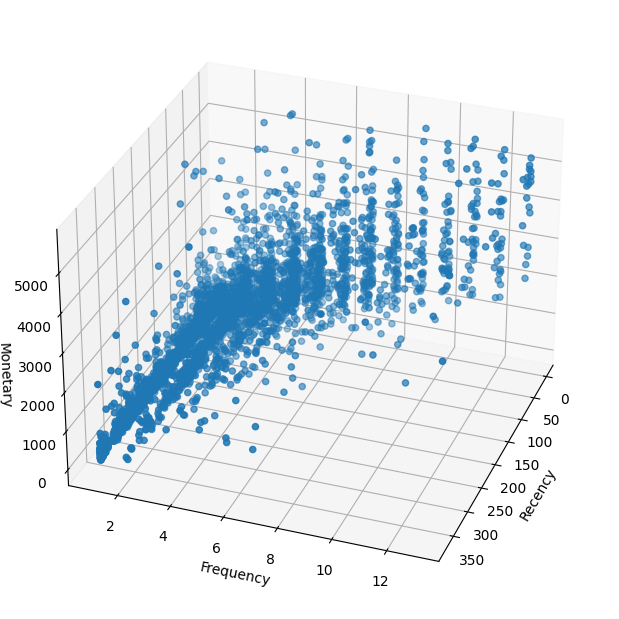

In [51]:
# создадим трёхмерный объект
fig = plt.figure(figsize=(6,6))
ax = Axes3D(fig)
# добавим дополнительную ось в объект картинки
fig.add_axes(ax)
ax.azim = 20
ax.elev = 30

# визуализируем данные, передав значения x, y, z, а также информацию о группировке данных по цветам
ax.scatter(
    rfm_table_cleaned['Recency'].to_list(), 
    rfm_table_cleaned['Frequency'].to_list(),
    rfm_table_cleaned['Monetary'].to_list()
)
# добавим оси
ax.set_xlabel('Recency')
ax.set_ylabel('Frequency')
ax.set_zlabel('Monetary');


Видно, что есть клиенты с большими значениями параметров Monetary и Frequency — вероятно, это лучшие клиенты, которые покупают чаще всего и приносят больше всего денег. Однако по общей массе точек сложно сказать, сколько кластеров у нас есть — скорее даже кажется, что пространство не поддаётся кластеризации.
Воспользуемся методами снижения размерности.

### 4.3 PCA
Начнём с метода главных компонент (PCA). Для его стабильной работы данные необходимо стандартизировать/нормализовать. 

Для удобства обернём эти шаги по предобработке данных в *pipeline*.

Создадим pipeline, в котором будут следующие шаги:
* стандартизация с помощью *StandardScaler* с параметрами по умолчанию; 
* метод главных компонент с двумя компонентами.

Обучим *pipeline* на *RFM*-таблице, очищенной от выбросов, и применим к ней трансформацию.

In [52]:
# наблюдения
X = rfm_table_cleaned.values
# создаем и обучаем pipeline
pl = pipeline.Pipeline([('scaler', preprocessing.StandardScaler()), ('pca', decomposition.PCA(n_components=2))])
pca_components = pl.fit_transform(X)

In [53]:
print('Доля дисперсии исходных данных, которую объясняет первая главная компонента:', pl['pca'].explained_variance_ratio_[0].round(2))
rfm_table_processed = pd.DataFrame(data=pca_components, columns=['axis-1', 'axis-2'])

Доля дисперсии исходных данных, которую объясняет первая главная компонента: 0.68


In [54]:
rfm_table_processed

,axis-1,axis-2
0,-2.135201,1.401596
1,3.447125,0.852872
2,0.629103,0.083217
3,0.152932,-0.720954
4,-1.888765,1.382645
...,...,...
4039,-0.873840,-0.729007
4040,-1.805975,1.051772
4041,-1.421026,0.168347
4042,-0.319330,-1.198285


Визуализируем пространство главных компонент после декомпозиции

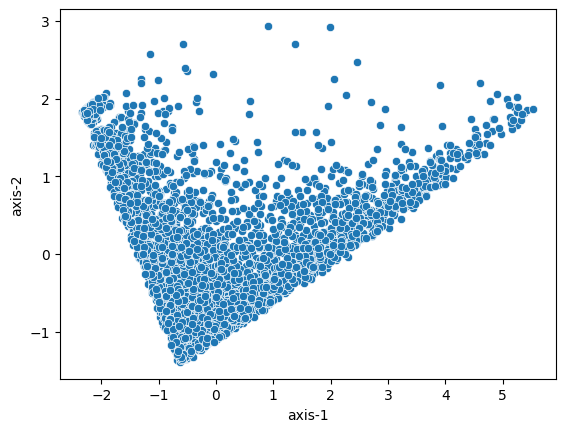

In [55]:
sns.scatterplot(data=rfm_table_processed, x='axis-1', y='axis-2');

Попробуем разделить это пространство главных компонент на сегменты. 
Судя по форме пространства, нам не подойдут алгоритмы, основанные на плотности, такие как *DBSCAN*, так как точки расположены очень близко друг к другу и большая часть точек будет определена в единый кластер, что не имеет смысла.

### 4.4 Подбор количества кластеров K-means
Воспользуемся методом k-means. 

Подберем оптимальное количество кластеров для метода k-means с помощью коэффициента силуэта, перебирая возможные значения от 2 до 10 включительно. 

В качестве значения параметра random_state возьмем число 42. Остальные параметры оставим по умолчанию.

In [56]:
siliuette_list = []
for n in range(2,11):
    km = cluster.KMeans(n_clusters=n, random_state=42)
    km.fit(pca_components)
    sil_score = metrics.silhouette_score(pca_components, km.labels_)
    siliuette_list.append([n, sil_score])
df_ac = pd.DataFrame(siliuette_list, columns=['number_of_clusters', 'sil_score'])
df_ac.sort_values(by = 'sil_score')

,number_of_clusters,sil_score
8,10,0.397843
7,9,0.408957
5,7,0.420295
6,8,0.420745
4,6,0.448006
3,5,0.454544
2,4,0.497553
0,2,0.500296
1,3,0.524230


Количество кластеров лучше взять 3, при этом количестве коэффициент силуэта максимальный

### 4.5 Подбор количества кластеров EM-алгоритм
Теперь возьмём EM-алгоритм.

Подберем оптимальное количество кластеров для EM-алгоритма (GaussianMixture) с помощью коэффициента силуэта, перебирая возможные значения от 2 до 10 включительно.
В качестве значения параметра random_state возьмем число 42. Остальные параметры оставим по умолчанию.

In [57]:
siliuette_list = []
for n in range(2,11):
    mix = mixture.GaussianMixture(n_components=n, random_state=42)
    mix.fit(pca_components)
    sil_score = metrics.silhouette_score(pca_components, mix.predict(pca_components))
    siliuette_list.append([n, sil_score])
df_ac = pd.DataFrame(siliuette_list, columns=['number_of_clusters', 'sil_score'])
df_ac.sort_values(by = 'sil_score')

,number_of_clusters,sil_score
8,10,0.109445
7,9,0.157627
6,8,0.196880
5,7,0.198851
3,5,0.246969
4,6,0.266670
0,2,0.342484
2,4,0.350103
1,3,0.436061


Количество кластеров лучше взять 3, т.к. коэффициент силуэта максимален

### 4.6 Обучение модели кластеризации
Посмотрим на распределение кластеров.
Выберем лучшую модель. Для модели K-Means коэффициент силуэта наибольший при оптимальном количестве кластеров.
Обучим K-Means с подобранным ранее количеством кластеров на декомпозированных данных. 

In [58]:
# обучаем модель с 3 кластерами
kmeans = cluster.KMeans(n_clusters=3, random_state=42)
kmeans.fit(pca_components)
rfm_table_processed['labels'] = kmeans.labels_
# количество клиентов в кластерах
rfm_table_processed['labels'].value_counts()

2    2269
0     999
1     776
Name: labels, dtype: int64

Визуализируем результаты кластеризации:

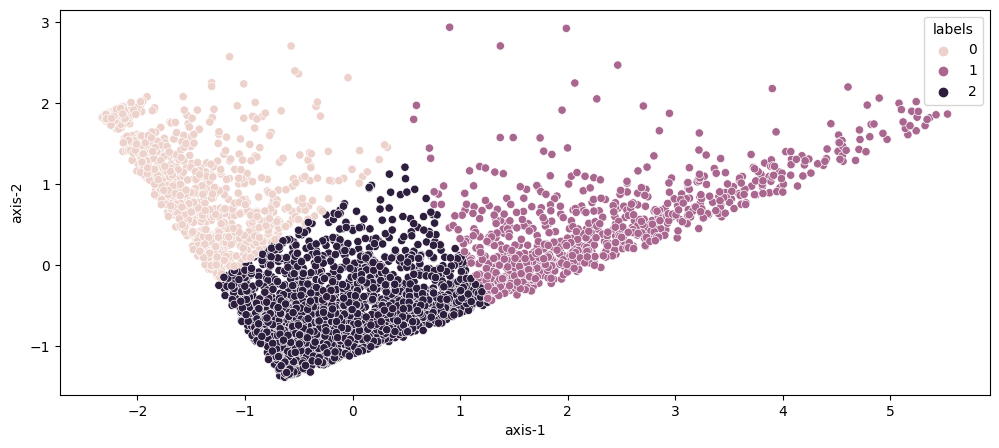

In [59]:
fig = plt.figure(figsize=(12, 5))
sns.scatterplot(
    data=rfm_table_processed, 
    x='axis-1', 
    y='axis-2', 
    hue='labels',
);

Итак, у нас есть три сегмента клиентов. Попробуем составить профиль для этих сегментов.

Для составления профиля кластеров нам необходимо вернуться от декомпозированных данных к RFM-таблице, очищенной от выбросов.  Сгруппируем RFM-таблицу по полученным кластерам и рассчитаем среднее по каждому из признаков.

In [60]:
# добавляем кластеры в очищенную таблицу
rfm_table_cleaned['labels'] = kmeans.labels_
# группируем по кластерам и вычисляем среднее
rfm_group = rfm_table_cleaned.groupby('labels').mean()
rfm_group

,Recency,Frequency,Monetary
labels,,,
0,253.474474,1.403403,386.277297
1,31.943299,7.068299,2657.746997
2,51.221684,2.329220,660.068947


### Полярная диаграмма
Применим один из способов визуализации профиля кластеров — Radar Chart (полярная, или лепестковая, диаграмма). Это графическое представление значений нескольких эквивалентных категорий в форме «паутины».
Radar Chart очень часто используется в контексте определения профиля кластеров. На концах «паутины» откладываются оси, которые соответствуют признакам, описывающим объекты. На каждой из осей для каждого кластера откладываются средние значения соответствующих характеристик. Соединив точки по осям, мы получаем многоугольник. 
Пример полярной диаграммы для задачи кластеризации учеников по интересам:

<img src=https://www.datanovia.com/en/wp-content/uploads/2020/12/radar-chart-in-r-customized-fmstb-radar-chart-1.png width=500>

На данной диаграмме мы видим визуализацию признаков для одного из кластеров. Видно, что ученики, принадлежащие к данному кластеру, в большей степени увлекаются музыкой (Music), а в меньшей степени — программированием (Programm).

В модуле graph_objects библиотеки plotly есть встроенная функция Scatterpolar, которая позволяет построить полярную диаграмму. На основе этой функции мы реализовали собственную функцию `plot_cluster_profile()`, которая позволяет визуализировать профиль каждого из кластеров в виде полярной диаграммы. У этой функции два параметра: grouped_data — сгруппированные по кластерам характеристики объектов (клиентов), n_clusters — количество кластеров. 

Главное условие использования полярной диаграммы — все признаки должны быть приведены к единому масштабу с помощью нормализации, где 1 будет означать максимум, а 0 — минимум. Шаг с нормализацией мы также добавили в реализацию функции plot_cluster_profile().

In [61]:
def plot_cluster_profile(grouped_data, n_clusters):
    # Нормализуем сгруппированные данные, приводя их к масштабу 0-1.
    scaler = preprocessing.MinMaxScaler()
    grouped_data = pd.DataFrame(scaler.fit_transform(grouped_data), columns=grouped_data.columns)
    # Создаем список признаков
    features = grouped_data.columns
    # Создаем пустую фигуру
    fig = go.Figure()
    # В цикле визуализируем полярную диаграмму для каждого кластера
    for i in range(n_clusters):
        # Создаем полярную диаграмму и добавляем ее на общий график
        fig.add_trace(go.Scatterpolar(
            r=grouped_data.iloc[i].values, # радиусы
            theta=features, # название засечек
            fill='toself', # заливка многоугольника цветом
            name=f'Cluster {i}', # название - номер кластера
        ))
    # Обновляем параметры фигуры
    fig.update_layout(
        showlegend=True, # отображение легенды
        autosize=False, # устаналиваем свои размеры графика
        width=800, # ширина (в пикселях)
        height=800, # высота (в пикселях)
    )
    # Отображаем фигуру
    fig.show()

# построение полярной диаграммы
plot_cluster_profile(rfm_group, 3)    

* Кластер 1 соответствует «лояльным» клиентам, которые приносят наибольший доход, совершают покупки чаще всего, а давность их последней покупки наименьшая.  
* Кластер 2 соответствует «промежуточным» клиентам, которые являются активными, но покупают не так часто и много, как лояльные клиенты. В то же время эти клиенты не являются «потерянными».  
* Кластер 0 соответствует «потерянным» клиентам, которые купили меньше всего товара, и их последняя покупка была совершена очень давно.


### 5. RFM-сегментация клиентов: часть 2

С помощью RFM-анализа нам удалось выделить три сегмента клиентов. Однако в маркетинге принято оперировать большим их количеством: обычно маркетологи стараются создать стратегию хотя бы для пяти-семи клиентских сегментов в градации от «лояльных» до «потерянных» с промежуточными категориями.

Поэтому, получив обратную связь от маркетологов, мы вновь принимаемся за работу, пытаясь модифицировать полученное решение.

Ранее мы производили кластеризацию в пространстве главных компонент. Вспомним, что PCA является линейным методом отображения исходного пространства признаков в его сжатую версию.



Воспользуемся алгоритмом t-SNE и трансформируем RFM-таблицу, очищенную от выбросов, в двухмерное представление. Также заранее позаботимся о масштабировании признаков.

Для удобства обернём шаги по предобработке данных в *pipeline*.

Создадим *pipeline*, который будет содержать следующие шаги:
* стандартизация с помощью *StandardScaler* с параметрами по умолчанию; 
* алгоритм t-SNE с двумя компонентами, параметрами perplexity=50 и random_state=100.

Обучим pipeline на RFM-таблице (очищенной от выбросов), полученной ранее, и применим к ней трансформацию.

Чему равно значение дивергенции Кульбака — Лейблера для обученного алгоритма t-SNE? Ответ округлите до двух знаков после точки-разделителя.

**Примечание:**
Напомним, что дивергенция Кульбака-Лейблера - это функция потерь, которая минимизируется при обучения алгоритма t-SNE. Она показывает меру расстояния между двумя распределениями. 

Оптимальное значение данной характеристики, найденное в процессе обучения алгоритма t-SNE, хранится в атрибуте kl_divergence_ объекта класса TSNE из библиотеки sklearn. Конечно же, предварительно модель необходимо обучить, чтобы получить это значение.

In [62]:
# матрица наблюдений без меток кластеров
X = rfm_table_cleaned.drop(['labels'], axis=1).values
# создаем пайплайн
pipe = pipeline.Pipeline([('scaler', preprocessing.StandardScaler()),
                          ('tsne', manifold.TSNE(n_components=2, perplexity=50, random_state=100))])
# обучаем pipeline
tsne = pipe.fit_transform(X)
# значение дивергенции Кульбака — Лейблера для обученного алгоритма t-SNE
pipe['tsne'].kl_divergence_

0.5415332317352295

In [63]:
rfm_table_processed = pd.DataFrame(data=tsne, columns=['axis-1', 'axis-2'])

Визуализировав пространство после декомпозиции с помощью t-SNE, мы получим следующую картину:


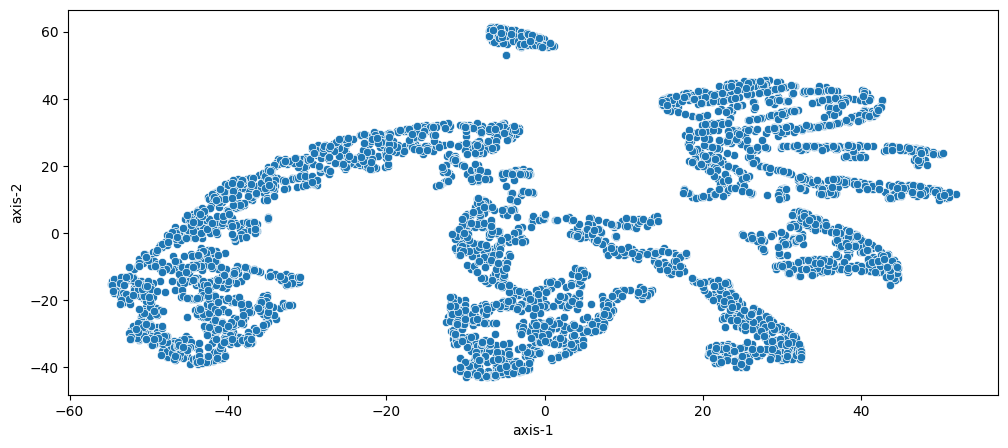

In [64]:
fig = plt.figure(figsize=(12, 5))
sns.scatterplot(data=rfm_table_processed, x='axis-1', y='axis-2');

Как и ожидалось от t-SNE, алгоритм сгруппировал наиболее похожие объекты в подобие кластеров, причём эти кластеры легко определить.

Теперь давайте воспользуемся алгоритмами кластеризации, чтобы сформировать новые сегменты клиентов.


### 5.1 Кластеризация KMeans
Попробуем воспользоваться методом k-means. 
Подберем оптимальное количество кластеров для метода k-means с помощью коэффициента силуэта, перебирая возможные значения от 3 до 8 включительно. 
В качестве значения параметра random_state возьмем число 42. Остальные параметры оставим по умолчанию.

In [65]:
# подбираем оптимальное количество кластеров
siliuette_list = []
for n in range(3,9):
    km = cluster.KMeans(n_clusters=n, random_state=42)
    km.fit(rfm_table_processed)
    sil_score = metrics.silhouette_score(rfm_table_processed, km.labels_)
    siliuette_list.append([n, sil_score])
df_ac = pd.DataFrame(siliuette_list, columns=['number_of_clusters', 'sil_score'])
df_ac.sort_values(by = 'sil_score')

,number_of_clusters,sil_score
0,3,0.434189
2,5,0.478028
3,6,0.479196
1,4,0.479278
5,8,0.482026
4,7,0.484495


Оптимальное количество кластеров 7 при максимальном коэффициенте  0,48

### 5.2 EM-алгоритм
Попробуем воспользоваться EM-алгоритом. 

Подберем оптимальное количество кластеров для EM-алгоритма (GaussianMixture)  с помощью коэффициента силуэта, перебирая возможные значения от 3 до 8 включительно. 

В качестве значения параметра random_state возьмем число 42. Остальные параметры оставим по умолчанию.

In [66]:
siliuette_list = []
for n in range(3,9):
    mix = mixture.GaussianMixture(n_components=n, random_state=42)
    mix.fit(rfm_table_processed)
    sil_score = metrics.silhouette_score(rfm_table_processed, mix.predict(rfm_table_processed))
    siliuette_list.append([n, sil_score])
df_ac = pd.DataFrame(siliuette_list, columns=['number_of_clusters', 'sil_score'])
df_ac.sort_values(by = 'sil_score')

,number_of_clusters,sil_score
4,7,0.411883
2,5,0.412347
0,3,0.427071
5,8,0.429173
3,6,0.457162
1,4,0.468827


Оптимальное количество кластеров 4 при коэффициенте 0,47

### 5.3 Агломеративная кластеризация
Попробуем воспользоваться алгоритмом алгомеративной кластеризации (AgglomerativeClustering).

Подберем оптимальное количество кластеров для алгоритма агломеративной кластеризации с помощью коэффициента силуэта, перебирая возможные значения от 2 до 8 включительно. 

Все параметры, за исключением числа кластеров, оставим по умолчанию.

In [67]:
siliuette_list = []
for n in range(2,9):
    agg = cluster.AgglomerativeClustering(n_clusters=n)
    agg.fit(rfm_table_processed)
    sil_score = metrics.silhouette_score(rfm_table_processed, agg.labels_)
    siliuette_list.append([n, sil_score])
df_ac = pd.DataFrame(siliuette_list, columns=['number_of_clusters', 'sil_score'])
df_ac.sort_values(by = 'sil_score')

,number_of_clusters,sil_score
0,2,0.379710
1,3,0.423116
2,4,0.456647
5,7,0.458636
4,6,0.469175
3,5,0.470394
6,8,0.479046


Оптимальное количество кластеров 8 при коэффициенте 0,48

### 5.4 Построение модели
Посмотрим на распределение кластеров.

Для AgglomerativeClustering с оптимальным количеством кластеров коэффициент силуэта наибольший?
Обучим лучшую модель с подобранным ранее количеством кластеров на декомпозированных данных. 

In [68]:
model = cluster.KMeans(n_clusters=7, random_state=42)
model.fit(rfm_table_processed)

KMeans(n_clusters=7, random_state=42)

Визуализируем результаты кластеризации:

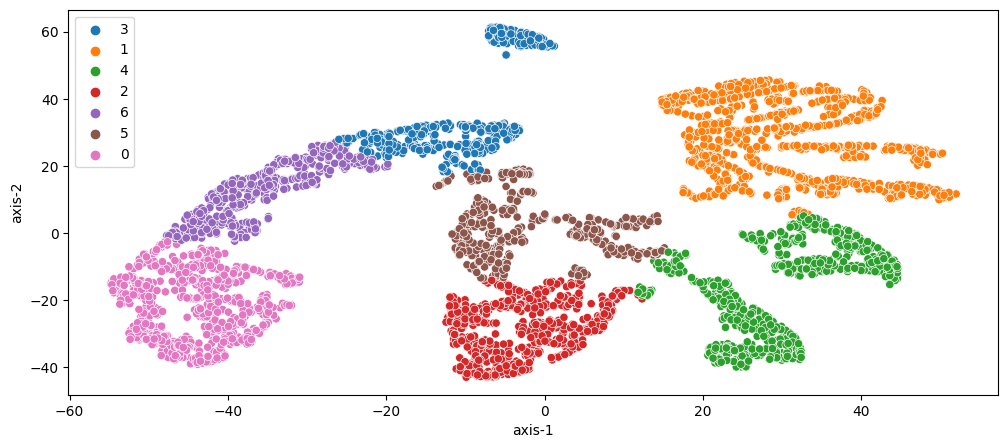

In [69]:
fig = plt.figure(figsize=(12, 5))
sns.scatterplot(data=rfm_table_processed, x='axis-1', y='axis-2', hue=model.labels_.astype('str'));

In [70]:
rfm_table_processed['labels'] = model.labels_
rfm_table_processed['labels'].value_counts()

1    914
4    683
0    656
2    543
5    446
6    405
3    397
Name: labels, dtype: int64


Итак, у нас есть 7 сегментов клиентов. Попробуем составить профиль для этих сегментов. 


### 5.5 Профиль кластеров

Для составления профиля кластеров нам необходимо вернуться от декомпозированных данных к RFM-таблице (очищенной от выбросов).

Сгруппируем RFM-таблицу по полученным кластерам и рассчитаем среднее по каждому из признаков. Для наглядности округлим все значения в столбцах до целого числа.

In [71]:
rfm_table_cleaned['labels'] = model.labels_
rfm7 = rfm_table_cleaned.groupby('labels').mean().round()
rfm7

,Recency,Frequency,Monetary
labels,,,
0,46.0,1.0,322.0
1,32.0,7.0,2417.0
2,40.0,2.0,614.0
3,313.0,1.0,261.0
4,40.0,3.0,995.0
5,196.0,2.0,670.0
6,181.0,1.0,273.0


### 5.6 Визуализация кластеров
Визуализируйем профили кластеров в виде полярной диаграммы на основе средних RFM-характеристик, вычисленных для каждого кластера.

In [72]:
# построение полярной диаграммы
plot_cluster_profile(rfm7, 7)  


* Кластер 1 соответствует «лояльным» клиентам, которые приносят наибольший доход, совершают покупки чаще всего, а давность их последней покупки наименьшая.
* Кластер 4 соответствует «перспективным» клиентам, которые являются активными покупателями, но покупают не так часто и не так много, как лояльные клиенты.
* Кластер 2 соответствует «подвисшим» клиентам, которые относительно недавно сделали несколько заказов на небольшие суммы. Потенциально эти клиенты могут быть переведены в кластер «перспективных».
* Кластер 5 соответствует клиентам «в зоне риска», которые несколько раз покупали товары на небольшие суммы, однако их последняя покупка была совершена более пяти месяцев назад.
* Кластер 0 соответствует клиентам-«новичкам», которые относительно недавно сделали один заказ на небольшую сумму. 
* Кластер 6 соответствует «спящим» или «почти потерянным» клиентам, которые сделали один заказ на маленькую сумму более семи месяцев назад и больше не возвращались.
* Кластер 3 соответствует «потерянным» клиентам, которые купили меньше всего товара, и их последняя покупка была совершена около года назад.

## 6. RFM-кластеризация клиентов: часть 3

Мы построили модель кластеризации для части клиентов. Теперь нужно сделать предсказание сегмента для клиентов, которые не попали в обучающую выборку.

Мы обучали наши алгоритмы кластеризации на сжатом с помощью t-SNE пространстве признаков. То есть, чтобы сделать предсказание для новых объектов, не попавших в выборку, нам необходимо будет совершить трансформацию признаков этих объектов в новое сжатое пространство. 

Однако проблема t-SNE заключается в том, что алгоритм непараметрический. Это значит, что он, в отличие от таких алгоритмов, как PCA и SVD, не создаёт явной функции отображения. Проще говоря, алгоритм трансформирует пространство признаков для обучающей выборки, но не запоминает, каким образом это делает. Это значит, что, передав в алгоритм новые объекты для сжатия пространства, мы получим абсолютно новое представление пространства, не имеющее отношения к тому, что мы построили для обучающей выборки. То есть произойдёт искажение, что может привести к неверным результатам кластеризации.

Именно поэтому у класса TSNE из библиотеки sklearn нет такого метода, как transform(), у него есть только метод fit_transform() — заново обучить алгоритм t-SNE и произвести трансформацию.

Как же тогда производить кластеризацию для новых объектов, если мы не можем сжимать размерность для новых данных?

Давайте сведём задачу кластеризации к задаче классификации. Действительно, у нас теперь есть истинные метки кластеров, а есть клиенты, которые описываются RFM-характеристиками. Давайте обучим модель, которая на основе RFM-характеристик будет предсказывать клиентский сегмент. 

### 6.1 Разделение данных на train и test

In [73]:
rfm_table_cleaned

,Recency,Frequency,Monetary,labels
CustomerID,,,,
12346,325,1,0.00,3
12347,2,7,4310.00,1
12348,75,4,1437.24,4
12349,18,1,1457.55,2
12350,310,1,294.40,3
...,...,...,...,...
18278,73,1,173.90,0
18280,277,1,180.60,3
18281,180,1,80.82,6


In [74]:
# Создаём матрицу наблюдений X и вектор правильных ответов y
X = rfm_table_cleaned.drop(['labels'], axis=1) #очищенная RFM-таблица
y = rfm_table_cleaned.labels #метки кластеров, предсказанные ранее
X_train, X_test, y_train, y_test = model_selection.train_test_split(X, y, test_size=0.2, random_state=42)
X_test

,Recency,Frequency,Monetary
CustomerID,,,
17676,4,6,1371.18
12552,39,1,317.82
15327,52,1,208.75
16023,46,3,719.81
17041,26,3,1055.69
...,...,...,...
17253,18,1,178.26
12968,112,1,135.95
17449,2,7,2500.21


Дальше нам осталось только построить несколько моделей и выбрать из них лучшую. 
Мы знаем, что алгоритм t-SNE является нелинейным методом понижения размерности. Можно смело предположить, что линейные модели, такие как логистическая регрессия, в данной задаче нам мало чем помогут.

Поэтому давайте сразу возьмём тяжелую артиллерию — ансамблевые алгоритмы. 

### Случайный лес
Начнём со случайного леса. С помощью GridSearchCV организуем перебор параметров случайного леса (RandomForestClassifier) на следующей сетке параметров:

```
param_grid = {
    'max_depth': range(5, 15),
    'criterion': ['gini', 'entropy'],
    'n_estimators': [100, 200, 500]
}
```
В качестве параметра random_state для модели случайного леса используем число 42.
В качестве метрики используем accuracy. Количество фолдов для кросс-валидации — 5.

1) Обучим GridSearchCV на тренировочной выборке. 
2) С помощью лучшей модели сделаем предсказание для тестовой выборки и рассчитаем метрику accuracy. 

In [80]:
param_grid = {
    'max_depth': range(5, 15),
    'criterion': ['gini', 'entropy'],
    'n_estimators': [100, 200, 500]
}
gs = model_selection.GridSearchCV(param_grid=param_grid,
                                  estimator=ensemble.RandomForestClassifier(random_state=42),
                                  cv=5,
                                  scoring='accuracy')
gs.fit(X_train, y_train)
y_pred_test = gs.predict(X_test)
y_pred_train = gs.predict(X_train)
print('Accuracy на тестовой выборке: {:.3f}'.format(metrics.accuracy_score(y_test, y_pred_test)))
print('Accuracy на тренировочной выборке: {:.3f}'.format(metrics.accuracy_score(y_train, y_pred_train)))

Accuracy на тестовой выборке: 0.985
Accuracy на тренировочной выборке: 1.000


In [78]:
gs.best_params_

{'criterion': 'gini', 'max_depth': 13, 'n_estimators': 200}

Значение метрики accuracy очень высокое, но не идеальное. Попробуем его улучшить, воспользовавшись бустингом.

### Градиентный бустинг
С помощью GridSearchCV организуем перебор параметров градиентного бустинга (GradientBoostingClassifier) на следующей сетке параметров:
```
param_grid = {
    'max_depth': range(3, 7),
    'learning_rate': [0.001, 0.01, 0.1],
    'n_estimators': [100, 200, 500]
}
```

В качестве параметра random_state для модели градиентного бустинга используем число 42.
В качестве метрики используем accuracy. Количество фолдов для кросс-валидации — 5. 

1) Обучим GridSearchCV на тренировочной выборке. 
2) С помощью лучшей модели сделаем предсказание для тестовой выборки и рассчитаем метрику accuracy. 

In [82]:
param_grid = {
    'max_depth': range(3, 7),
    'learning_rate': [0.001, 0.01, 0.1],
    'n_estimators': [100, 200, 500]
}
gs_boost = model_selection.GridSearchCV(param_grid=param_grid,
                                  estimator=ensemble.GradientBoostingClassifier(random_state=42),
                                  cv=5,
                                  scoring='accuracy',
                                  n_jobs=-1)
gs_boost.fit(X_train, y_train)
gs_boost.best_params_
y_pred_test = gs_boost.predict(X_test)
y_pred_train = gs_boost.predict(X_train)
print('Accuracy на тестовой выборке: {:.3f}'.format(metrics.accuracy_score(y_test, y_pred_test)))
print('Accuracy на тренировочной выборке: {:.3f}'.format(metrics.accuracy_score(y_train, y_pred_train)))

Accuracy на тестовой выборке: 0.983
Accuracy на тренировочной выборке: 1.000


In [83]:
gs_boost.best_params_

{'learning_rate': 0.1, 'max_depth': 4, 'n_estimators': 200}

Мы справились с проблемой непараметричности t-SNE и смогли перейти от решения задачи кластеризации к задаче классификации. Теперь у нас есть модель, которая на основе RFM-характерик клиента автоматически определяет его сегмент.

В заключение отметим, что сегментация клиентов не ограничивается только RFM-анализом. Что ещё можно сделать?

* Выделить оптовиков в отдельный сегмент. В таком случае идея метода RFM расширяется путём добавления в датасет информации о среднем количестве покупаемого товара за один заказ. То есть аббревиатура RFM превращается в RFMQ, где Q — среднее количество товаров в одном заказе.
* Произвести кластерный анализ товаров на основе их описания и сформировать категории, по которым совершаются покупки.
* Рассчитать частоту покупки каждой категории товаров для каждого клиента. Эта информация может стать основой для построения модели кластеризации и сегментирования клиентов по их интересам.
* Наконец, воспользоваться информацией о сезонности покупок и добавить в модель информацию о частоте покупок клиентов в каждый из месяцев. Так можно определить, какие клиенты являются постоянными, то есть их покупки не зависят от сезона, а какие покупают товары только в преддверии праздников. Эта информация позволит экспериментировать с маркетинговой кампанией и повышать лояльность клиентов.